# FCA

Technical Challenge for Data Science Candidates

This workbook loads a pickle file from the prior notebook.

Visualisation this uses the output pickle files from the loading notebook.
I can load the categorised numeric data or the scaled data.

It's an iterative process. I usually look at the numeric data first to see if there any major splits in the dataset.

In [1]:
import numpy as np
import pandas as pd
import math
import json

from os import path

import scipy.stats as st
import statsmodels as sm
import statsmodels.api as smi

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn import metrics 

from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns

pd.__version__

'0.24.2'

In [2]:
# If you turn this feature on, you can display each result as it happens.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# this is the local Utility module and it reloaded each time.
from fca import Utility

In [4]:
%load_ext autoreload
%autoreload 1
%aimport fca

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# My utility singleton.
i0 = Utility.instance()

## Visualisations

There is a lot of data which slows down the data-processing, because of that I take a sample.

In [6]:
# Use the dataframe in the form of last of these
df2 = pd.read_pickle("catted.pickle")
df2 = pd.read_pickle("coded.pickle")
df2 = pd.read_pickle("scaled.pickle")

# I may use some models with fit() methods
X = df2
y = df2.y

In [7]:
## Remove the columns with 0 for correlations
# I added these columns to denote NA, they correlate very highly with their source feature, so I'll remove them for now.
cols = list(X.columns)
cols1 = list(filter(lambda x: x.endswith('0'), cols))
cols2 = set(cols).difference(cols1)

In [8]:
# I will use a split here. There is a lot of data and some of the methods can be slow.
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [9]:
# Default case is take a small sample

X = X_test[cols2]
y = y_test

In [10]:
## Do not use this by default

# Another variant is to check when the outcome is true (or false)
# This can trap conditioned outcomes

if False:
    set(df2.y)
    X = df2[df2.y > 0][cols2]
    y = df2.y

In [11]:
X.head()
X.info()

,contact,loan,month,age,day_of_week,job,y,duration,education,previous,...,euribor3m,cons.price.idx,campaign,nr.employed,poutcome,cons.conf.idx,default,emp.var.rate,pdays,marital
31692,-0.75857,-0.319712,0.762558,0.477486,-0.003301,1.737926,-0.356309,-0.074380,0.695924,-0.349494,...,-1.322795,-1.179380,-0.565922,-0.940281,-0.372802,-1.231034,0.513260,-1.197935,0.194144,0.283741
12569,-0.75857,-0.319712,-0.530547,-0.578062,-0.718834,-0.880230,-0.356309,-0.471640,-0.441119,-0.349494,...,0.771846,0.591424,-0.565922,0.845170,-0.372802,-0.474791,0.513260,0.839061,0.194144,0.283741
5084,1.31827,-0.319712,0.762558,0.861322,-1.434368,-0.007511,2.806550,1.842495,1.264445,-0.349494,...,0.712460,0.722722,-0.204909,0.331680,-0.372802,0.886447,0.513260,0.648092,0.194144,0.283741
13951,-0.75857,-0.319712,-0.530547,1.245157,-1.434368,0.865207,-0.356309,-0.298080,-0.441119,-0.349494,...,0.773575,0.591424,-0.204909,0.845170,-0.372802,-0.474791,-1.946613,0.839061,0.194144,0.283741
34728,-0.75857,2.184721,0.762558,-0.865939,-0.003301,0.428848,-0.356309,1.109686,0.695924,-0.349494,...,-1.357965,-1.179380,0.156105,-0.940281,-0.372802,-1.231034,0.513260,-1.197935,0.194144,-1.358578


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8238 entries, 31692 to 8479
Data columns (total 21 columns):
contact           8238 non-null float64
loan              8238 non-null float64
month             8238 non-null float64
age               8238 non-null float64
day_of_week       8238 non-null float64
job               8238 non-null float64
y                 8238 non-null float64
duration          8238 non-null float64
education         8238 non-null float64
previous          8238 non-null float64
housing           8238 non-null float64
euribor3m         8238 non-null float64
cons.price.idx    8238 non-null float64
campaign          8238 non-null float64
nr.employed       8238 non-null float64
poutcome          8238 non-null float64
cons.conf.idx     8238 non-null float64
default           8238 non-null float64
emp.var.rate      8238 non-null float64
pdays             8238 non-null float64
marital           8238 non-null float64
dtypes: float64(21)
memory usage: 1.4 MB


## Correlations

Although one can search the correlation matrix, it's usually easiest to look at a plot.
It's helpful to cluster to similar groups

In [12]:
d0 = { '01': ['age', 'marital', 'education', 'job'],
    '02': ['default', 'housing', 'loan'],
    '03': ['contact', 'month', 'day_of_week', 'duration'],
    '04': ['campaign', 'pdays', 'previous', 'poutcome'],
    '05': ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed' ],
    '06': ['y'] }

cols = list(i0.flatten(d0.values()))

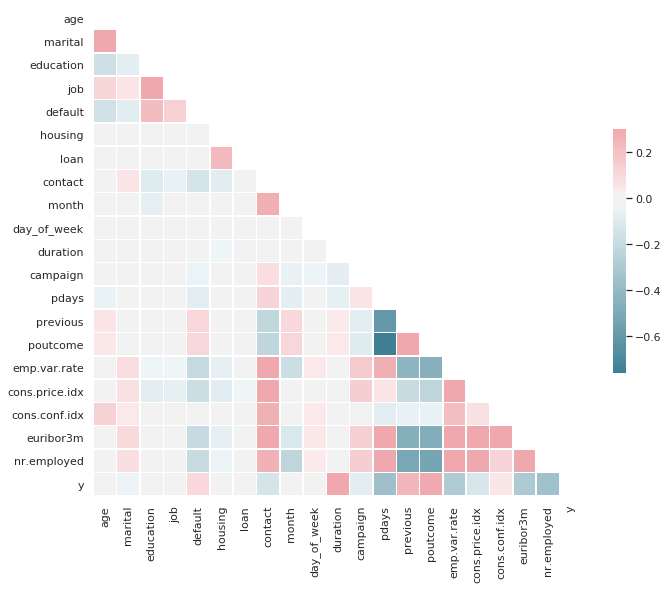

In [13]:
sns.set(style="white")

# Compute the correlation matrix
# Put the output back in
X1 = X[cols].copy()
X1['y'] = y
corr = X1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig("cache/bak/corr.jpeg", dpi=150)


## Density Plots

Very often, the features that are highly-correlated with others can be removed. 

Features usually appear in groups - socio-economic versus process-oriented. And usually it is preferable to choose just one variable for each group.

This dataset is unusual because there are two processes at work. 

 - Campaign Effectiveness
 - Credit-checking
 
This forms a funnel which we aren't in a position to test. It would be useful if there was a second outcome variable that is *applied-for* and then, if approved, then the *subscribed* (or *y*) variable.

#### Demographic features

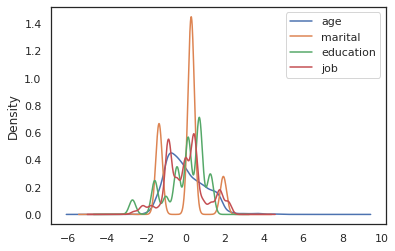

In [14]:
# Check the age shape

X[['age', 'marital', 'education', 'job']].plot.density()

plt.savefig("cache/bak/age-marital.jpeg", dpi=150)

#### Campaign features

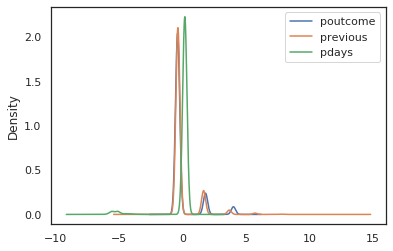

In [15]:
# These seem to nearly identical
X[['poutcome', 'previous', 'pdays']].plot.density()
plt.savefig("cache/bak/pdays-poutcome.jpeg", dpi=150)

#### Socio-economic: euribor3m cluster

These seem to be related.

Looking at these. It might be the future-value of the loan at the time the loanee applied. 
The most information would then be in the price

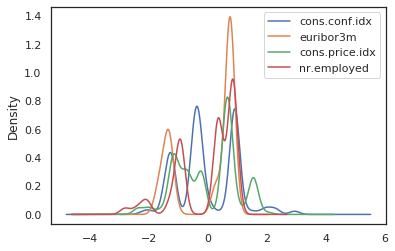

In [16]:
X[['cons.conf.idx', 'euribor3m', 'cons.price.idx', 'nr.employed']].plot.density()
plt.savefig("cache/bak/euribor-cons.jpeg", dpi=150)

### Pair-plot

This plot is a bit hard to interpret, but the hope is that obvious distributions, like age, will (or can be made to) align with other features.

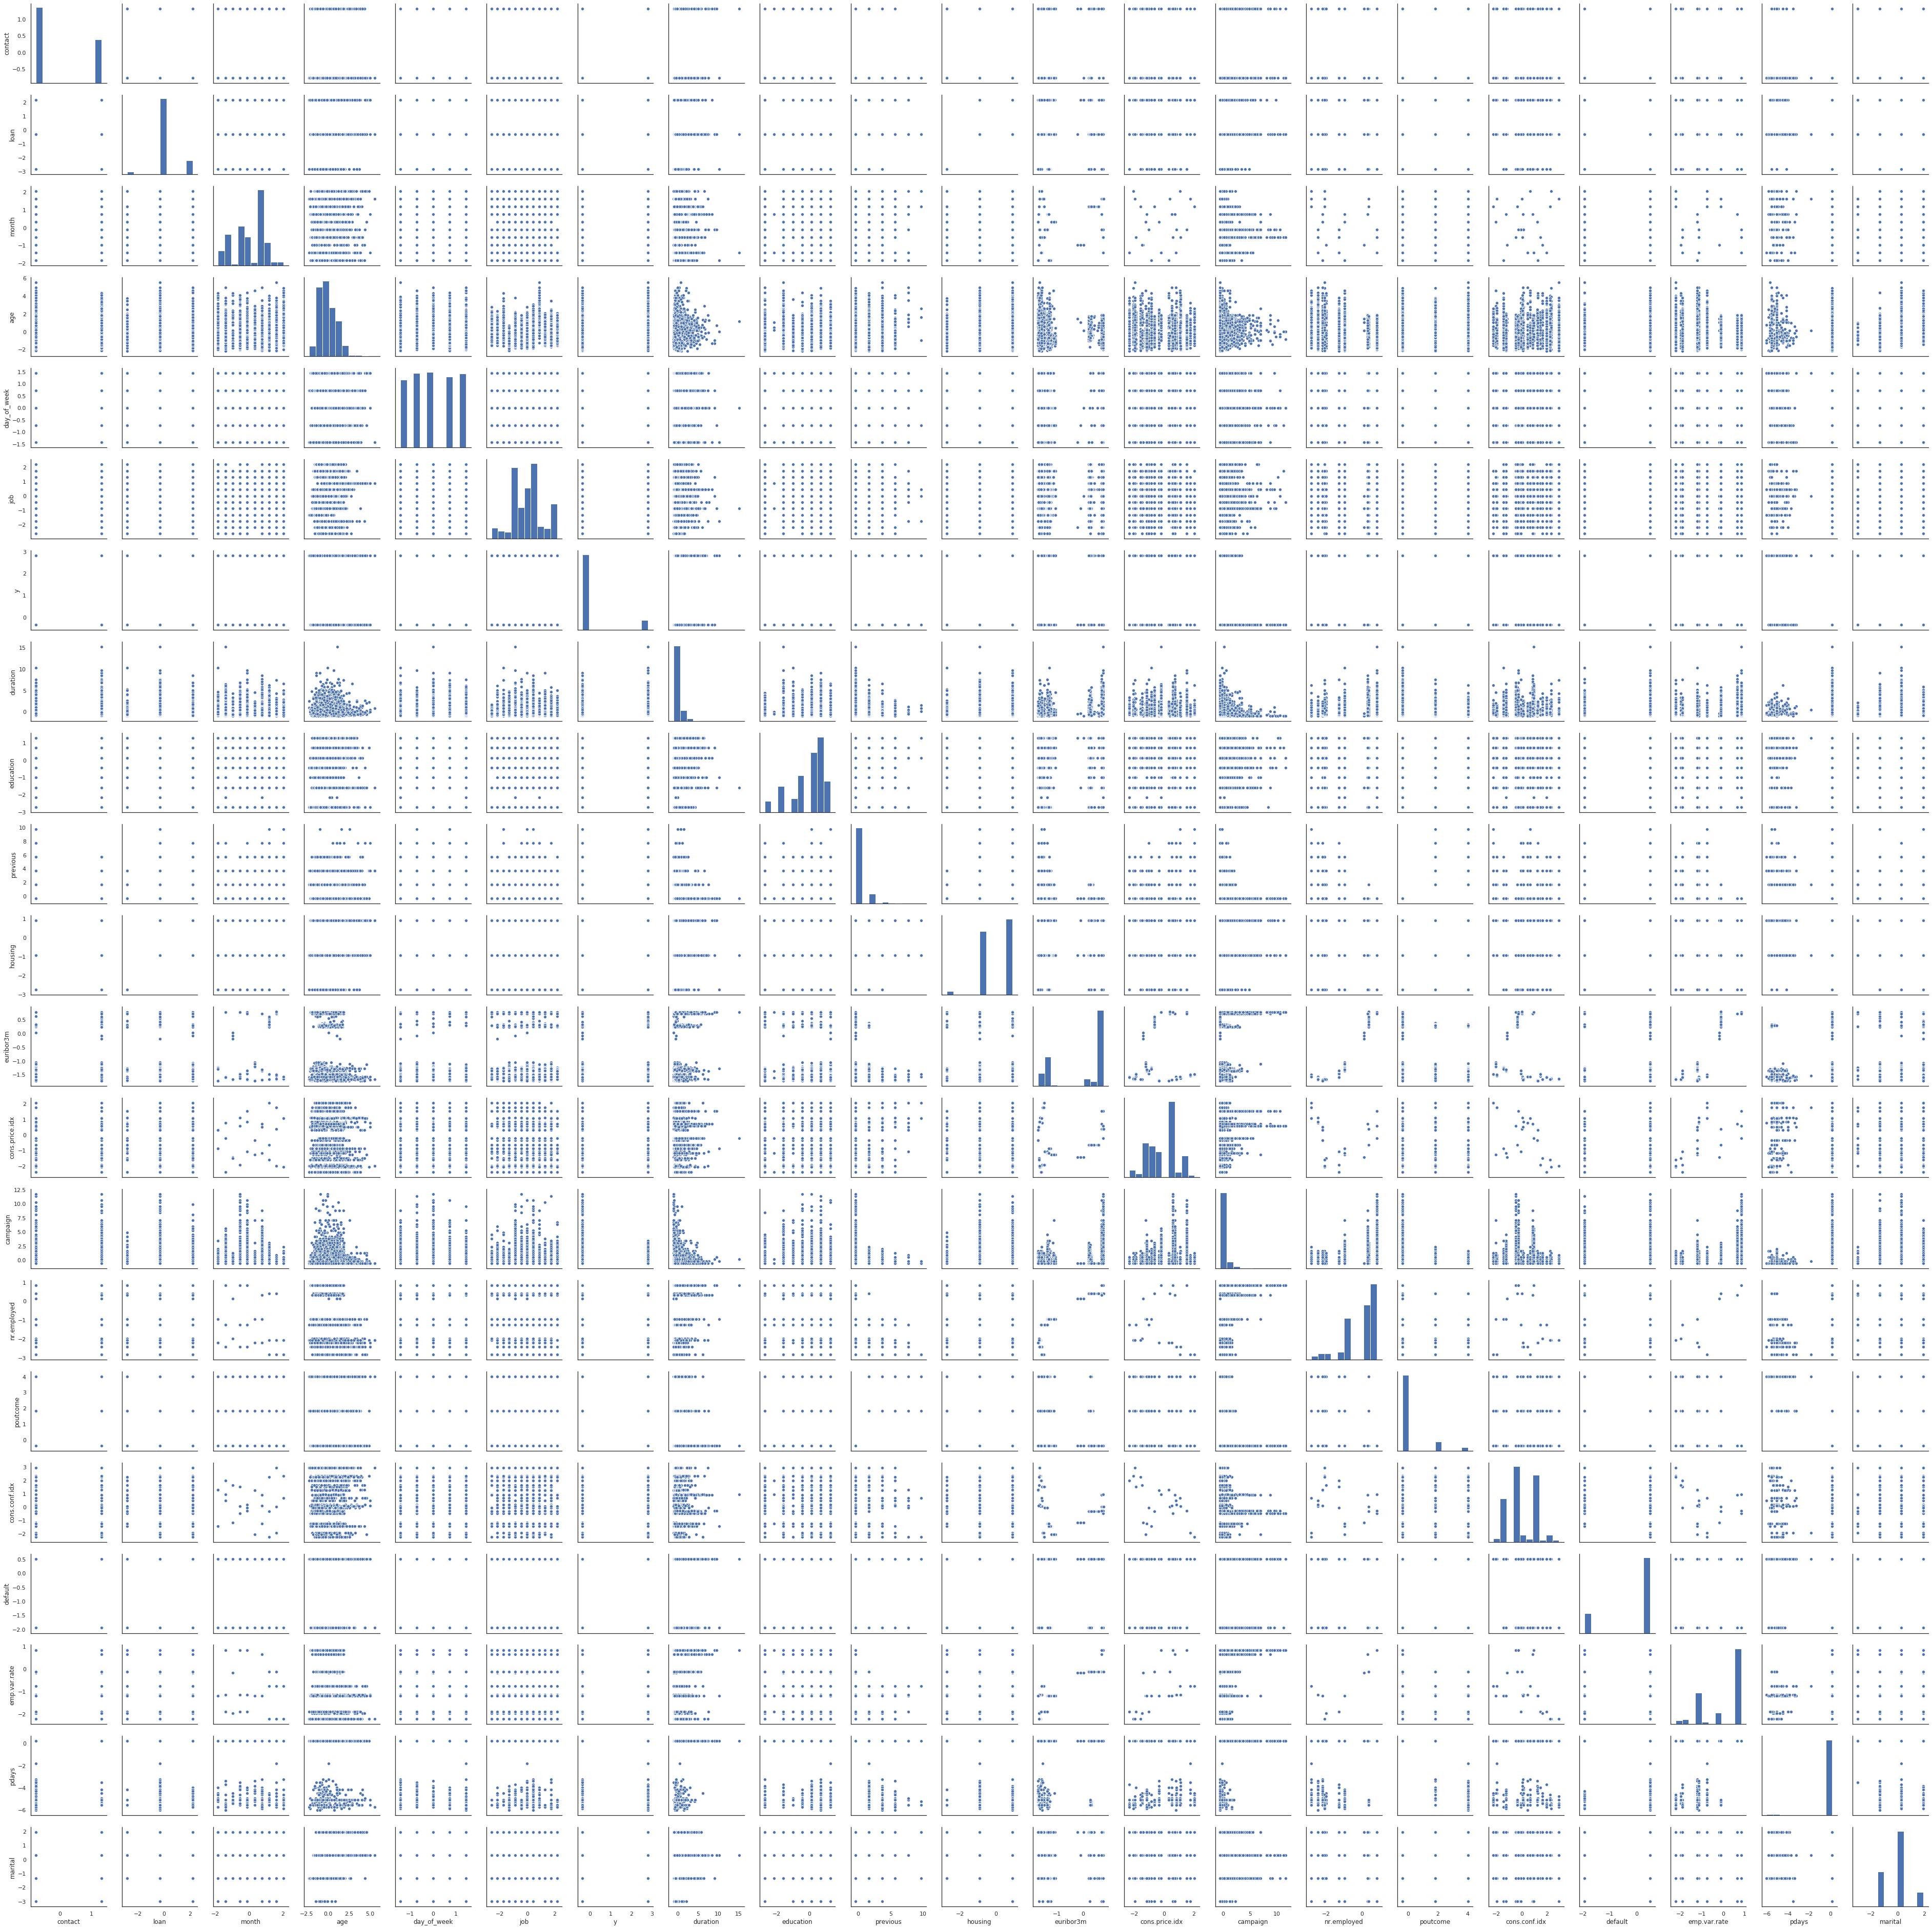

In [17]:
# A very time-consuming pair plot even on the sample

sns.pairplot(X)
plt.savefig("cache/bak/pairplot.jpeg", dpi=150)

### Violin Plots

These can be used as density plots and to inspect a correlation.

The most useful insight is the nr.employed plot

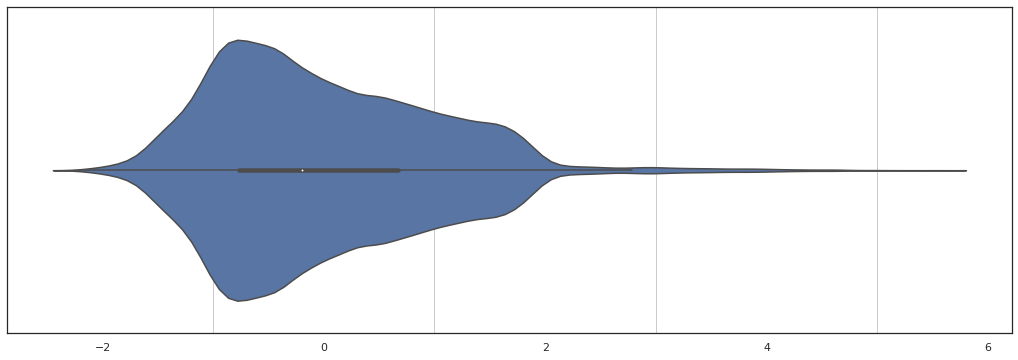

In [18]:
# Violin plot: age

from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot(x=['age'], data=df2)

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

ax1.grid(which='minor', axis='x', linewidth=1)

#### Violin plot: nr.employed

This suggests that the socio-economic indicators prevented subscriptions being given.

The correlation with output is split about 5099. When less than that, it was 50:50 if there was a subscription. Above that level, it was 95% certain there would be none.

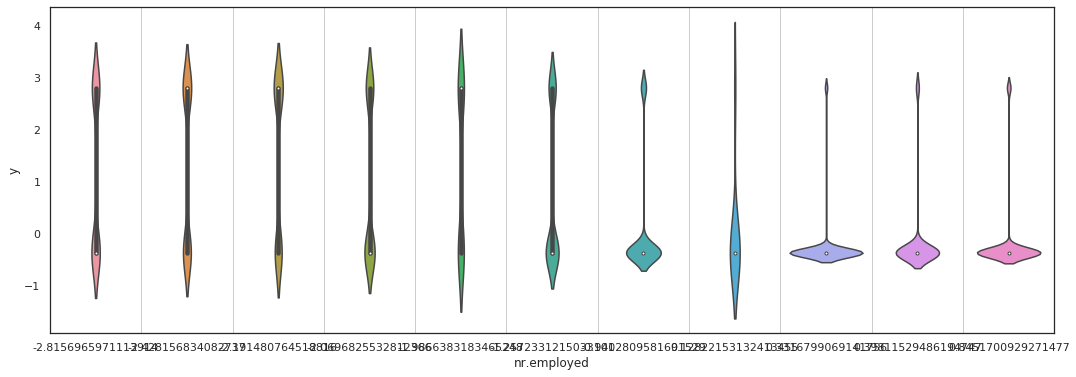

In [19]:
from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(18,6))

ax1 = sns.violinplot(x=df2['nr.employed'], y=df2['y'])

ax1.minorticks_on()
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))

ax1.grid(which='minor', axis='x', linewidth=1)

plt.savefig("cache/bak/nr-employed.jpeg", dpi=150)

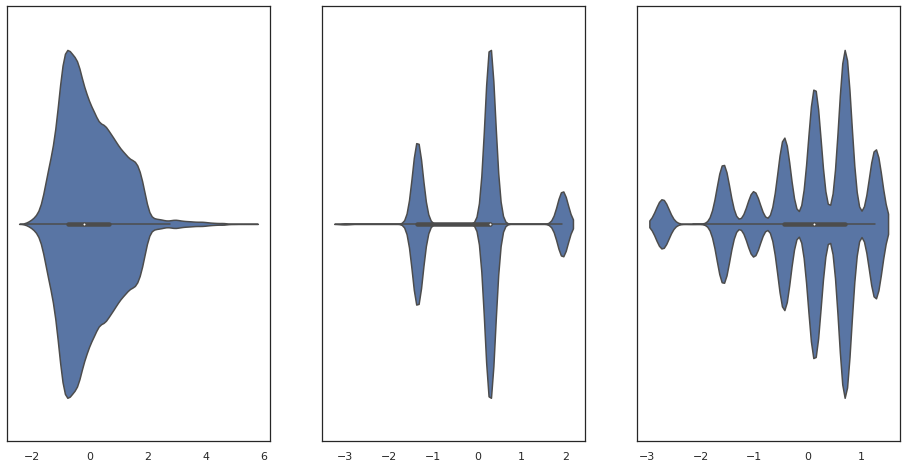

In [20]:
#### Closer look at Demographics

fig, axs = plt.subplots(figsize=(16,8), ncols=3)

sns.violinplot(x=['age'], data=df2, ax=axs[0])
sns.violinplot(x=['marital'], data=df2, ax=axs[1])
sns.violinplot(x=['education'], data=df2, ax=axs[2])